In [1]:
import torch
import torch.nn as nn
import torchaudio

import math

import mne

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

from utils.dataset import CustomDataset

In [2]:
device = torch.device("cuda")

In [3]:
# pulled from Dr. Karpathy's minGPT implementation
class GELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

In [4]:
class BrainDecoderBlock(nn.Module):
    def __init__(self, k, input_dims=320, skip=True):
        super().__init__()

        self.skip = skip

        self.conv1 = nn.Conv1d(input_dims, 320, kernel_size=3, dilation=2**((2*k)%5), padding="same")
        self.conv2 = nn.Conv1d(320, 320, kernel_size=3, dilation=2**((2*k+1)%5), padding="same")
        self.conv3 = nn.Conv1d(320, 640, kernel_size=3, dilation=2, padding="same")

        self.bnorm1 = nn.BatchNorm1d(320)
        self.bnorm2 = nn.BatchNorm1d(320)

        self.gelu = GELU()

        # channel dim
        self.glu = nn.GLU(dim=1)

    def forward(self, x):
        output = self.conv1(x)
        output = self.bnorm1(output)
        output = self.gelu(output)

        if self.skip:
            # channel dim res connection
            output = output + x

            skip = output

        output = self.conv2(output)
        output = self.bnorm2(output)
        output = self.gelu(output)

        if self.skip:
            output = output + skip

        output = self.conv3(output)
        output = self.glu(output)

        return output

In [5]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, num_harmonics, dropout=0.1):
        super().__init__()
        # position preprocessing
        easycap_montage = mne.channels.read_custom_montage("./data/umich/electrode_positions.sfp")

        info = mne.create_info([str(i+1) for i in range(in_channels)], sfreq=500, ch_types="eeg")
        info.set_montage(easycap_montage, on_missing="ignore")

        layout = mne.channels.find_layout(info)
        two_dim_pos = layout.pos[:, :2]

        # normalize 0-1
        two_dim_pos[:, 0] -= min(two_dim_pos[:, 0])
        two_dim_pos[:, 1] -= min(two_dim_pos[:, 1])

        two_dim_pos[:, 0] /= max(two_dim_pos[:, 0])
        two_dim_pos[:, 1] /= max(two_dim_pos[:, 1])

        self.input_channels = torch.tensor(two_dim_pos)
        
        # spatial attention calculation params

        self.z_trainable = torch.randn((out_channels, num_harmonics, num_harmonics), dtype=torch.cfloat)
        self.z_trainable = torch.nn.parameter.Parameter(torch.transpose(self.z_trainable.view(1, out_channels, num_harmonics, num_harmonics).repeat(in_channels, 1, 1, 1), 0, 1))

        self.k = self.l = torch.linspace(1, num_harmonics, num_harmonics).repeat(in_channels, num_harmonics, 1)

        # other stuff
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)

        self.softmax = nn.Softmax(dim=0)

        self.dropout = nn.Dropout(dropout)
    
    def _apply(self, fn):
        super(SpatialAttention, self)._apply(fn)

        self.k = fn(self.k)
        self.l = fn(self.l)
        self.input_channels = fn(self.input_channels)

        return self

    def forward(self, x):
        # x dims - batch_size, C, T

        term_1 = torch.transpose(torch.cos(2 * np.pi * (self.k * self.input_channels[:, 0].view(-1, 1, 1) + torch.transpose(self.l, 1, -1) * self.input_channels[:, 1].view(1, -1, 1, 1))), 2, 3)
        term_2 = torch.transpose(torch.sin(2 * np.pi * (self.k * self.input_channels[:, 0].view(-1, 1, 1) + torch.transpose(self.l, 1, -1) * self.input_channels[:, 1].view(1, -1, 1, 1))), 2, 3)

        a_j = torch.sum(self.z_trainable.real * term_1 + self.z_trainable.imag * term_2, dim=(1, 2, 3)).repeat(x.shape[0], 1).view(x.shape[0], -1, 1)

        output = self.conv1(x)

        output = self.dropout(self.softmax(a_j)) * output

        return output.type(torch.float32)

In [6]:
class BrainDecoder(nn.Module):
    def __init__(self, input_channels, num_k, num_freq_bands, num_subjects):
        super().__init__()

        self.spatial_attention = SpatialAttention(input_channels, 270, 32, 0.1)

        self.conv1 = nn.Conv1d(270, 270, kernel_size=1)

        self.subject_layers = []
        for i in range(num_subjects):
            self.subject_layers += [nn.Conv1d(270, 270, kernel_size=1)]
        self.subject_layers = nn.ModuleList(self.subject_layers)

        self.decoder_blocks = []

        for i in range(num_k):
            if i == 0:
                self.decoder_blocks += [BrainDecoderBlock(i+1, 270, False)]
            else:
                self.decoder_blocks += [BrainDecoderBlock(i+1, 320, True)]

        self.decoder_blocks = nn.ModuleList(self.decoder_blocks)

        self.conv2 = nn.Conv1d(320, 640, kernel_size=1)
        self.final_conv = nn.Conv1d(640, num_freq_bands, kernel_size=1)

    def forward(self, x, subject_num):
        output = self.spatial_attention(x)

        output = self.conv1(output)

        final_output = torch.zeros_like(output)

        for _, i in enumerate(subject_num):
            final_output[_] = self.subject_layers[int(i)](output[_])

        for block in self.decoder_blocks:
            final_output = block(final_output)
        
        final_output = self.conv2(final_output)
        final_output = self.final_conv(final_output)

        return final_output

In [7]:
num_subjects = 49
T_out = 49

bundle = torchaudio.pipelines.WAV2VEC2_XLSR53
wave2vec = bundle.get_model().to(device)

In [8]:
batch_size = 128

exclude = [2, 7, 9, 23, 24, 27, 28, 29, 30, 31, 32, 33, 43, 46, 47, 49]

dataset = CustomDataset(data_dir="./data/umich", T_out=T_out, num_subjects=num_subjects, exclude=exclude)

train_set = torch.utils.data.Subset(dataset, range(int(len(dataset) * 0.8)))
val_set = torch.utils.data.Subset(dataset, range(int(len(dataset) * 0.8), int(len(dataset))))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

100%|██████████| 49/49 [02:12<00:00,  2.71s/it]


Brain data shape: torch.Size([7986, 61, 49])
Waveform shape: torch.Size([23859, 16000])
Subject num shape: torch.Size([7986])
Audio sampling rate (Hz): 16000
Brain data sampling rate (Hz): 500


In [9]:
sample = next(iter(train_loader))

with torch.inference_mode():
    emission, _ = wave2vec(sample[1][0].view(1, -1).to(device).type(torch.float32))

features, _ = wave2vec.extract_features(sample[1][0].view(1, -1).to(device).type(torch.float32))
print(len(features))

24


In [10]:
save_temperature = False

class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.temperature = torch.nn.parameter.Parameter(torch.randn(1, dtype=torch.float32))

        self.cross_entropy = nn.CrossEntropyLoss()

        self.exponentiated_temperatures = []

    def forward(self, brain_latents, audio_latents):
        # dims = batch_size, frequency_dim, temporal_dim
        brain_latents = brain_latents.reshape((brain_latents.shape[0], -1)) # [batch_size, frequency_dim * temporal_dim]
        # dims = batch_size, frequency_dim, temporal_dim
        audio_latents = audio_latents.reshape((audio_latents.shape[0], -1)) # [batch_size, frequency_dim * temporal_dim]

        logits = brain_latents @ audio_latents.T
        logits_T = logits.T

        labels = torch.arange(brain_latents.shape[0]).to(device)

        # exponentiate and clip to max 100
        exponentiated_temperature = torch.exp(self.temperature)
        if exponentiated_temperature > 100: exponentiated_temperature = 100

        loss = ((self.cross_entropy(logits, labels) + self.cross_entropy(logits_T, labels)) / 2) / exponentiated_temperature

        if save_temperature:
            self.exponentiated_temperatures += [exponentiated_temperature.item()]
        
        return loss

In [11]:
C = 61
F = 1024

brain_decoder = BrainDecoder(input_channels=C, num_k=5, num_freq_bands=F, num_subjects=num_subjects)
brain_decoder.to(device)

clip = CLIP()
clip.to(device)

# batch_size, C, T
test_data = torch.randn((32, C, T_out))

# expected output dims: batch_size, F, T_out
output = brain_decoder(test_data.to(device), torch.zeros((32)))
output.shape

/tmp/ipykernel_8566/1636232819.py:8: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(easycap_montage, on_missing="ignore")


torch.Size([32, 1024, 49])

In [12]:
# regression loss
regression_loss = nn.MSELoss()

In [13]:
optimizer = torch.optim.Adam(list(brain_decoder.parameters()) + list(clip.parameters()), lr=3e-4)

In [14]:
model_name = "june_6_run_1"

print("Running " + model_name)

EPOCHS = 50

N_loss = 10


epoch_train_losses = []
epoch_val_losses = []

wave2vec.eval()

# training loop
for epoch in range(EPOCHS):
    print("Epoch: " + str(epoch))

    # set to train mode
    brain_decoder.train()
    clip.train()

    for (brain_data, audio_data, subject_num) in train_loader:
        optimizer.zero_grad()

        brain_data = brain_data.to(device).type(torch.float32)
        audio_data = audio_data.to(device).type(torch.float32)

        # wave2vec processing
        with torch.inference_mode():
            features, _ = wave2vec.extract_features(audio_data)

        # pull from last 4 layers
        semantic_features = (features[23] + features[22] + features[21] + features[20]) / 4    # dims -> batch_size, T, F
        semantic_features = torch.transpose(semantic_features, 1, 2)

        semantic_features = (semantic_features - torch.mean(semantic_features)) / torch.std(semantic_features) 

        # brain decoder processing
        brain_output = brain_decoder(brain_data, subject_num)

        # propogate gradients
        loss = clip(brain_output, semantic_features)
        # loss = regression_loss(brain_output, semantic_features.clone())
        loss.backward()

        optimizer.step()
    
    # set to eval mode
    brain_decoder.eval()
    clip.eval()

    # train loss calculation loop
    train_losses = []
    with torch.no_grad():
        for i, (brain_data, audio_data, subject_num) in enumerate(train_loader):
            brain_data = brain_data.to(device).type(torch.float32)
            audio_data = audio_data.to(device).type(torch.float32)

            # wave2vec processing
            with torch.inference_mode():
                features, _ = wave2vec.extract_features(audio_data)

            # pull from last 4 layers
            semantic_features = (features[23] + features[22] + features[21] + features[20]) / 4    # dims -> batch_size, T, F
            semantic_features = torch.transpose(semantic_features, 1, 2)

            semantic_features = (semantic_features - torch.mean(semantic_features)) / torch.std(semantic_features) 

            # brain decoder processing
            brain_output = brain_decoder(brain_data, subject_num)

            # loss calcs
            if i == 0:
                save_temperature = True
                loss = clip(brain_output, semantic_features)
                save_temperature = False
            else:
                loss = clip(brain_output, semantic_features)
            # loss = regression_loss(brain_output, semantic_features.clone())

            train_losses += [loss.item()]

            if i == N_loss-1:
                print("Train loss: " + str(np.mean(np.array(train_losses))))
                epoch_train_losses += [np.mean(np.array(train_losses))]
                break
    
    # val loss calculation loop
    val_losses = []
    with torch.no_grad():
        for (brain_data, audio_data, subject_num) in val_loader:
            brain_data = brain_data.to(device).type(torch.float32)
            audio_data = audio_data.to(device).type(torch.float32)

            # wave2vec processing
            with torch.inference_mode():
                features, _ = wave2vec.extract_features(audio_data)

            # pull from last 4 layers
            semantic_features = (features[23] + features[22] + features[21] + features[20]) / 4    # dims -> batch_size, T, F
            semantic_features = torch.transpose(semantic_features, 1, 2)

            semantic_features = (semantic_features - torch.mean(semantic_features)) / torch.std(semantic_features) 

            # brain decoder processing
            brain_output = brain_decoder(brain_data, subject_num)

            # loss calcs
            loss = clip(brain_output, semantic_features)
            # loss = regression_loss(brain_output, semantic_features.clone())

            val_losses += [loss.item()]
    
    print("Val loss: " + str(np.mean(np.array(val_losses))))
    epoch_val_losses += [np.mean(np.array(val_losses))]


torch.save(brain_decoder, "./saved_models/" + model_name + "_brain_decoder")
torch.save(clip, "./saved_models/" + model_name + "_clip")

Running june_6_run_1
Epoch: 0
Train loss: 2.4294673204421997
Val loss: 1.5437415838241577
Epoch: 1
Train loss: 10.067713499069214
Val loss: 1.5646697924687312
Epoch: 2
Train loss: 8.01313910484314
Val loss: 1.7084327385975764
Epoch: 3
Train loss: 3.2796948671340944
Val loss: 1.6087697744369507
Epoch: 4
Train loss: 1.8575770735740662
Val loss: 1.4789792390970082
Epoch: 5
Train loss: 2.202860963344574
Val loss: 1.4713931725575373
Epoch: 6
Train loss: 1.6715921998023986
Val loss: 1.4650304500873272
Epoch: 7
Train loss: 1.566966438293457
Val loss: 1.505438621227558
Epoch: 8
Train loss: 1.482497239112854
Val loss: 1.4581687908906202
Epoch: 9
Train loss: 1.4791399002075196
Val loss: 1.4662086963653564
Epoch: 10
Train loss: 1.7472416400909423
Val loss: 1.714642543059129
Epoch: 11
Train loss: 1.4787517547607423
Val loss: 1.4511601191300612
Epoch: 12
Train loss: 1.5655919551849364
Val loss: 1.4504882647440984
Epoch: 13
Train loss: 1.4912660837173461
Val loss: 1.4758772941736074
Epoch: 14
Train 

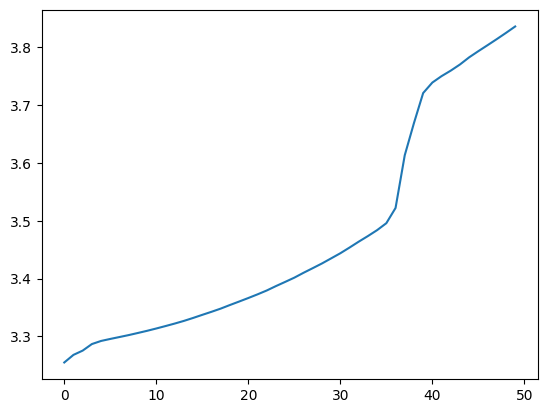

In [15]:
temps = clip.exponentiated_temperatures
plt.plot(temps)

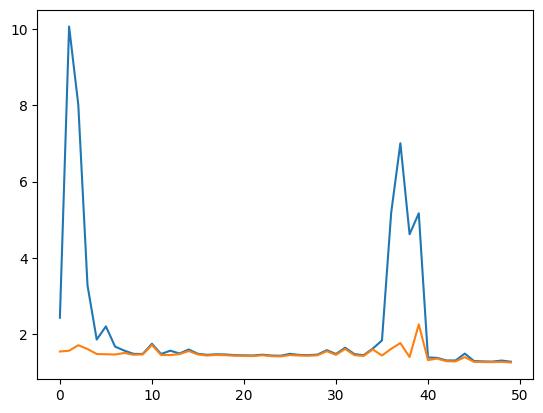

In [16]:
plt.plot(epoch_train_losses, label="Train loss")
plt.plot(epoch_val_losses, label="Val loss")

plt.savefig("./loss_graphs/" + model_name + ".png")